<a href="https://colab.research.google.com/github/CharlesHenrynoah/classificationimage/blob/main/Classification_balls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Importation des outils nécessaires**

On prépare l'usine en rassemblant tous les outils et équipements nécessaires. Onn rassemble les machine de traitement tensorflow et keras, les convoyeurs (image_dataset_from_directory), les différents parties des machines de traitement (layers, models, regularizers), et les systèmes de gestion de la production (callbacks comme EarlyStopping, ReduceLROnPlateau, TensorBoard).
Je m'assure également que toutes les routes et chemins (pathlib et os) sontdéfinis pour l'accès aux matières premières et produits finis, et je synchronise les horloges pour un suivi précis du temps de production (datetimme).

In [54]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory, image
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
import pathlib
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

**2. Montage du Google Drive**

Vous établissez une connexion sécurisée entre votre usine et un entreprôt distant où sont stockées les matières premières (images des balles). C'est comme ouvrir un canal logistique entre l'usine et une centre de distribution

In [55]:
# Montage du Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**3. Définir les chemins et les paramètres**

base_dir, c'est l'adresse principale de l'entrepôt où toutes les balles sont stockées avant le traitement. Chaque balle est redimensionnée à une taille standard pour s'assurer qu'elles sont toutes traitées uniformément par les machines.
Les balles sont traitées en lots pour optimiser l'efficacité et la vitesse de production

In [56]:
# Définir les chemins et les paramètres
base_dir = '/content/drive/MyDrive/balls'
img_height = 180
img_width = 180
batch_size = 32

**4. Fonction pour obtenir les classes et leur mapping**

Nous avons un grand entrepôt contenant dufférents types de balles, comme des balles de basket , des balles de football , on doit d'abord identifier quels types de balles sont présents dans l'entrepôt. On va parcourir chaque section de l'entrepôt pour vérifier si elle contient des balles et identifier de quel  type de balle il s'agit.
Pour chaque type de balle trouvé, on enregistre son nom et on crée une correspondance avec l'emplacement spécifique dans l'entrepôt où ce type de balle est stocké. On effectue une carte complète de l'entrepôt indiquant où chaque type de balle est stocké, ce qui facilite le traitement et la gestion ultérieure.

In [57]:
# Fonction pour obtenir les classes et leur mapping
def get_class_mapping(data_dir):
    class_mapping = {}
    for subdir in os.listdir(data_dir):
        subdir_path = os.path.join(data_dir, subdir)
        if os.path.isdir(subdir_path):
            class_name = subdir.lower()
            class_mapping[class_name] = subdir  # Utilise le nom du dossier comme clé
            print(f"Trouvé: Classe {class_name}")  # Debugging print
    return class_mapping

**5. Obtenir le mapping des classes**

On a réalisé une sorte d'audit ou d'inventaire de notre entrepôt de données d'entraînement. On identifie et catalogue chaque type de balle en fonction de son emplacement dnas le répertoire de formation, ce qui nous permet de savoir où trouver chaque type de balle pour les étapes suivantes du traitement

In [58]:
# Obtenir le mapping des classes
class_mapping = get_class_mapping(os.path.join(base_dir, 'train'))
print("Mapping des classes:", class_mapping)

Trouvé: Classe wrecking ball
Trouvé: Classe wiffle ball
Trouvé: Classe water polo ball
Trouvé: Classe sepak takraw ball
Trouvé: Classe screwballs
Trouvé: Classe tether ball
Trouvé: Classe rubberband ball
Trouvé: Classe tennis ball
Trouvé: Classe volley ball
Trouvé: Classe pokeman balls
Trouvé: Classe soccer ball
Trouvé: Classe puffballs
Trouvé: Classe paint balls
Trouvé: Classe football
Trouvé: Classe crystal ball
Trouvé: Classe golf ball
Trouvé: Classe meat ball
Trouvé: Classe eyeballs
Trouvé: Classe marble
Trouvé: Classe chrochet ball
Trouvé: Classe cricket ball
Trouvé: Classe medicine ball
Trouvé: Classe cannon ball
Trouvé: Classe billiard ball
Trouvé: Classe brass
Trouvé: Classe bowling ball
Trouvé: Classe baseball
Trouvé: Classe beachballs
Trouvé: Classe basketball
Trouvé: Classe buckeyballs
Mapping des classes: {'wrecking ball': 'wrecking ball', 'wiffle ball': 'wiffle ball', 'water polo ball': 'water polo ball', 'sepak takraw ball': 'sepak takraw ball', 'screwballs': 'screwballs'

**6. Filtrer les classes que nous voulons utiliser**

On affine notre inventaire pour ne conserver que les types de balles que nous avons décidé de traiter dans l'usine. On sélectionne spécifiquement les balles de basket et les balles de football, puis on filtre l'inventaire pour nous concentrer uniquement sur ces types de balles. Cela nous permet de nous assurer que l'usine traite uniquement les elements pertinents.

In [59]:
# Filtrer les classes que nous voulons utiliser
selected_classes = ['basketball', 'soccer ball']  # Utiliser les noms des dossiers directement
filtered_class_mapping = {k: v for k, v in class_mapping.items() if k in selected_classes}
print("Filtered class mapping:", filtered_class_mapping)


Filtered class mapping: {'soccer ball': 'soccer ball', 'basketball': 'basketball'}


**7.Charger les ensembles de données**

On prépare les matières premières (images) en les collectant, en les étiquetant, en les prétraitant et en les organisant en lots prêts pour la ligne de production. Cela permet de s'assurer que toutes les tailles sont uniformes et correctement étiquetées avant dêtre traitées par les machine de l'usine.


In [60]:
# Charger les ensembles de données
def load_data(data_dir, class_mapping):
    data_dir = pathlib.Path(data_dir)
    images = []
    labels = []
    for class_name, class_dir in class_mapping.items():
        class_path = data_dir / class_dir
        if class_path.is_dir():
            class_images = list(class_path.glob('*.jpg'))
            images.extend([str(img) for img in class_images])  # Convertir en chaînes de caractères
            labels.extend([class_name] * len(class_images))  # Utiliser le nom de la classe comme étiquette
    print(f"Loaded {len(images)} images from {data_dir}")

    ds = tf.data.Dataset.from_tensor_slices((images, labels))

    def process_path(file_path, label):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [img_height, img_width])
        label = tf.convert_to_tensor(selected_classes.index(label.numpy().decode('utf-8')))
        return img, label

    ds = ds.map(lambda x, y: tf.py_function(process_path, [x, y], [tf.float32, tf.int32]))
    ds = ds.map(lambda x, y: (tf.ensure_shape(x, [img_height, img_width, 3]), tf.ensure_shape(y, [])))
    return ds

train_ds = load_data(os.path.join(base_dir, 'train'), filtered_class_mapping)
val_ds = load_data(os.path.join(base_dir, 'valid'), filtered_class_mapping)
test_ds = load_data(os.path.join(base_dir, 'test'), filtered_class_mapping)
print("Data loaded")


Loaded 278 images from /content/drive/MyDrive/balls/train
Loaded 10 images from /content/drive/MyDrive/balls/valid
Loaded 10 images from /content/drive/MyDrive/balls/test
Data loaded


**8.Prétraitement des images**

On prépare et organise les lots de balles de manière à optimiser le flux de production. On utilise des techniques d'automatisation et d'optimisation pour nous assurer que les balles sont traitées de manière efficace et continue, réduisant les temps d'attente et améliorant la performance globale de la ligne de production.

In [61]:
# Prétraitement des images
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
print("Datasets prepared with caching, shuffling, and prefetching")

Datasets prepared with caching, shuffling, and prefetching


****

**Augmentation des données**

Nous préparons un ensemble de transformations pour tester et améliorer les images des balles de sport, similaire à une usine qui effectue divers tests de qualité sur les balles pour s'assurer qu'elles sont robustes et haute de qualité. Les processus de retournement, de rotation et de zoom aléatoires appliqués aux images permettent de s'assurer que le modèle peut apprendre des caractéristiques invariantes et devenir plus robuste aux variations dans les données d'entraînement.

In [62]:
# Augmentation des données
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])
print("Data augmentation model created")

Data augmentation model created


**Ajouter l'augmentation des données au jeu de données d'entraînement**

Nous intégrons des test de qualité directement dans la chaîne de production des balles de spots. Ces test tests simulent différentes conditions et manipulations pour s'assurer que les balles sont robustes et de hautes qualité. De la même manière, l'augmentation des données est appliquées aux images d'entraînement pour rendre le modèle plus robuste aux variations et améliorer sa capacité à généraliser à de nouvelles données.

In [63]:
# Ajouter l'augmentation des données au jeu de données d'entraînement
def apply_augmentation(x, y):
    x = data_augmentation(x, training=True)
    return x, y

train_ds = train_ds.map(apply_augmentation, num_parallel_calls=AUTOTUNE)
print("Datasets prepared for training")

Datasets prepared for training


**9. Définir le modèle**

On configure une ligne de production sophistiquée dans une usine de fabrication de balles de sport. On utilise des machines préconfigurées et optimisées, ajoutez des étapes supplémentaires pour affiner et régulariser le processus et intégrez des controles de qualités pour garantir que les balles produites sont de haute qualitéet correctement classés. De la même manière le modèle de deep leraning est défini en utilisant un modèle pré-entrainé, avec des couches supplémentaires pour extraire les caractéristiques importantes et produire les prédictions.


In [104]:
# Définir le modèle
num_classes = len(selected_classes)

# Utiliser un modèle pré-entraîné (Transfer Learning)
base_model = tf.keras.applications.ResNet50(input_shape=(img_height, img_width, 3),
                                            include_top=False,
                                            weights='imagenet')
base_model.trainable = False  # Geler les couches de base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Ajouter du dropout pour la régularisation
    layers.Dense(num_classes, activation='softmax')
])


In [110]:
# Compiler le modèle
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Entraîner le modèle
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
        TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)
    ]
)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step - accuracy: 0.8050 - loss: 1.5343 - val_accuracy: 1.0000 - val_loss: 0.7634 - learning_rate: 0.0010
Epoch 2/20


In [111]:
# Sauvegarder le modèle dans le format recommandé
model.save('/content/drive/MyDrive/ball_classification_model.keras')

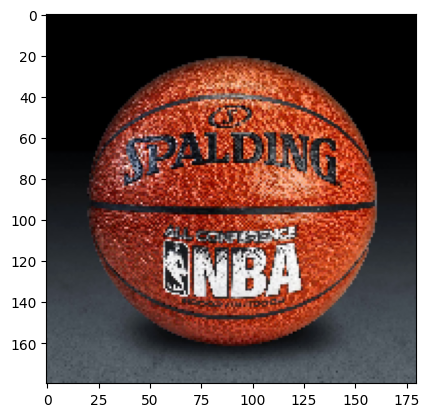

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Cette image est très probablement un soccer ball avec une confiance de 65.49%


In [92]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, regularizers

# Définir les chemins et les paramètres
img_height = 180
img_width = 180
num_classes = 2  # Nombre de classes (basketball, soccer ball)

# Redéfinir l'architecture du modèle
def create_model():
    base_model = tf.keras.applications.ResNet50(input_shape=(img_height, img_width, 3),
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False  # Geler les couches de base

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),  # Ajouter du dropout pour la régularisation
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Créer le modèle et charger les poids
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Charger les poids du modèle sauvegardé
model.load_weights('/content/drive/MyDrive/ball_classification_model.keras')

# Chemin vers votre image dans Google Drive
image_path = '/content/drive/MyDrive/basketball.jpg'  # Assurez-vous que ce chemin est correct

# Charger l'image
img = image.load_img(image_path, target_size=(img_height, img_width))
plt.imshow(img)
plt.show()

# Prétraiter l'image
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Créer un batch

# Normaliser l'image
img_array = img_array / 255.0

# Faire une prédiction
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Afficher la classe prédite
class_names = ['basketball', 'soccer ball']  # Remplacer par les noms de vos classes
predicted_class = class_names[np.argmax(score)]

print(f"Cette image est très probablement un {predicted_class} avec une confiance de {100 * np.max(score):.2f}%")

